In [48]:
OUTPUT_FOLDER = "/scratch/aakash_ks.iitr/dr-scnn/"
DATA_FOLDER = "/scratch/aakash_ks.iitr/data/diabetic-retinopathy/"
# TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train/'
TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train_c/'
TEST_DATA_FOLDER = DATA_FOLDER + 'test/'

In [49]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from PIL import Image

plt.rcParams['figure.dpi'] = 100

In [50]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import timm

In [51]:
NUM_CLASSES = 5

class CFG:
    seed = 42
    N_folds = 5
    train_folds = [0] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=True # use half precision
    workers = 16

    model_name = "resnet50.a1_in1k"
    epochs = 50
    cropped = True
    # weights =  torch.tensor([0.206119, 0.793881],dtype=torch.float32)

    clip_val = 1000.
    batch_size = 64
    # gradient_accumulation_steps = 1

    lr = 6e-3
    weight_decay=1e-2
    
    resolution = 224
    samples_per_class = 1000

In [52]:
device = torch.device(CFG.device)

In [53]:
# train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels.csv'))
train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels_cropped.csv'))
train_data

,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
...,...,...,...,...
35103,35104,35121,44347_right,0
35104,35105,35122,44348_left,0
35105,35106,35123,44348_right,0
35106,35107,35124,44349_left,0


In [54]:
# remove all images from the csv if they are not in the folder
lst = map(lambda x: x[:-5], os.listdir(TRAIN_DATA_FOLDER))
train_data = train_data[train_data.image.isin(lst)].reset_index(drop=True)
len(train_data)

19944

In [55]:
from torchvision.transforms import functional as func

class CustomTransform:
    def __init__(self, output_size=(CFG.resolution, CFG.resolution), radius_factor=0.9):
        self.output_size = output_size
        self.radius_factor = radius_factor

    def __call__(self, img):
        # Assuming img is a PIL Image
        # Normalize and preprocess as previously defined
        img = func.resize(img, int(min(img.size) / self.radius_factor))
        img_tensor = func.to_tensor(img)
        mean, std = img_tensor.mean([1, 2]), img_tensor.std([1, 2])
        img_normalized = func.normalize(img_tensor, mean.tolist(), std.tolist())
        kernel_size = 15
        padding = kernel_size // 2
        avg_pool = torch.nn.AvgPool2d(kernel_size, stride=1, padding=padding)
        local_avg = avg_pool(img_normalized.unsqueeze(0)).squeeze(0)
        img_subtracted = img_normalized - local_avg
        center_crop_size = int(min(img_subtracted.shape[1:]) * self.radius_factor)
        img_cropped = func.center_crop(img_subtracted, [center_crop_size, center_crop_size])

        # Apply augmentations
        img_resized = func.resize(img_cropped, self.output_size)

        return img_resized

In [56]:
transform = v2.Compose([
    CustomTransform(),
    v2.ToDtype(torch.float32, scale=False),
])

In [57]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        folder,
        data,
        transforms,
    ):
        self.folder = folder
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data.loc[index]
        image = Image.open(f"{self.folder}{d.image}.jpeg")
        image = self.transforms(image)
        label = d.level

        return image, torch.tensor(label, dtype=torch.long)

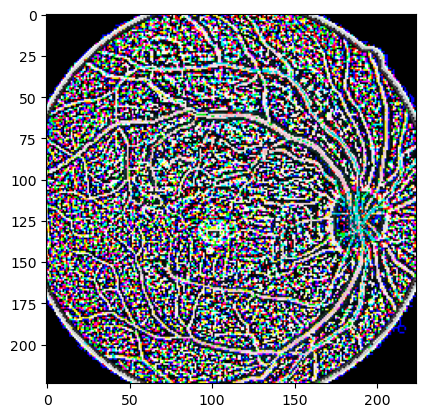

In [58]:
# visualize the transformations
train_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, transform)
image, label = train_dataset[15]
transformed_img_pil = func.to_pil_image(image)
plt.imshow(transformed_img_pil)

note that the severity levels in test / query images are 0, 1, 2, 3 ie only 4 levels.

In [59]:
os.listdir(TEST_DATA_FOLDER )

['DR2', 'Normal', 'DR3', 'DR1']

In [60]:
# taking a random image from the test folder
query_img = Image.open(TEST_DATA_FOLDER + '/DR2/1ffa93c6-8d87-11e8-9daf-6045cb817f5b..JPG')

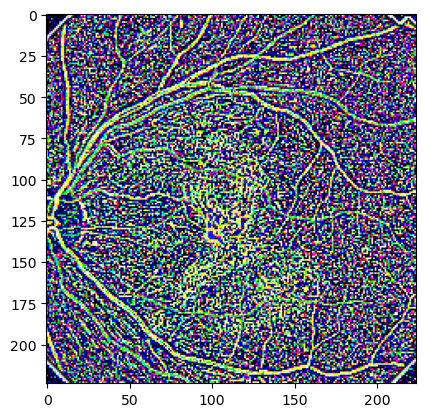

In [62]:
# query image
# apply the same transformation to the test image
transformed_query_img = transform(query_img)
transformed_img_pil = func.to_pil_image(transformed_query_img)
plt.imshow(transformed_img_pil)

In [63]:
# load model
model = torch.load(OUTPUT_FOLDER + 'best_model_fold_0.pth', map_location=device)
model.eval()
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=CFG.workers)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Function to get embeddings from a model
def get_embeddings(dataloader, model):
    with torch.no_grad():
        embeddings = []
        for images, _ in dataloader:
            images = images.to(device)
            output = model(images)
            embeddings.append(output.cpu().numpy())
        embeddings = np.vstack(embeddings)
    return embeddings

# Get embeddings for all images
all_embeddings = get_embeddings(dataloader, model)

# Query image (assuming it is loaded and transformed similarly)
query_image = transform(query_img).unsqueeze(0).to(device)  # Unsqueeze to add the batch dimension
query_embedding = model(query_image).cpu().numpy()

# Find the k nearest images
k = 5
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(all_embeddings)
distances, indices = nbrs.kneighbors(query_embedding)

# Resulting indices are the indices of the closest images in your dataset
print("Indices of nearest images:", indices)
print("Distances:", distances)